## 1. セットアップ

In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import sys
import os
from datetime import datetime

warnings.filterwarnings('ignore')
from pathlib import Path

rootPath = Path.cwd().parent
sys.path.append(str(rootPath))

# Trip-based SequenceCreator をインポート
from src.timeseries_processing.trip_sequence_creator import TripSequenceCreator
from src.timeseries_processing import DataSplitter, DataStandardizer
from src.timeseries_processing.improved_feature_groups import feature_groups_trip_based

feature_groups = feature_groups_trip_based

# 日本語フォント設定（可視化用）
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

print(f"TensorFlow version: {tf.__version__}")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

data_path = f'{rootPath}/data/delay_analysis_trip_based.csv'
print(f"Loading data from {data_path}...")
model_path = f'{rootPath}/files/model/best_delay_model_trip_based_20251102_061332.h5'
print(f"Loading model from {model_path}...")

2025-11-03 00:24:28.107730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1
Analysis started at: 2025-11-03 00:24:30
Loading data from /workspace/data/delay_analysis_trip_based.csv...
Loading model from /workspace/files/model/best_delay_model_trip_based_20251102_061332.h5...


## 2. データ読み込みと前処理

In [2]:
# データ読み込み
print("Loading dataset...")
delay_features = pd.read_csv(data_path)

print(f"Dataset shape: {delay_features.shape}")
print(f"\nColumn names ({len(delay_features.columns)} features):")
print(delay_features.columns.tolist())

# 基本統計
print(f"\nBasic statistics:")
print(f"- Unique trips: {delay_features['trip_id'].nunique():,}")
print(f"- Date range: {delay_features['time_bucket'].min()} to {delay_features['time_bucket'].max()}")
print(f"- Mean delay: {delay_features['arrival_delay'].mean():.2f} seconds")
print(f"- prev_stop_delay non-zero: {(delay_features['prev_stop_delay'] != 0).sum():,}")

Loading dataset...
Dataset shape: (154205, 43)

Column names (43 features):
['route_id', 'trip_id', 'direction_id', 'stop_id', 'stop_sequence', 'start_date', 'scheduled_arrival_time', 'actual_arrival_time', 'time_bucket', 'arrival_delay', 'prev_stop_delay', 'prev_2_stop_delay', 'route_delay_trend_60min', 'route_hourly_delay_7d_avg', 'route_delay_volatility_3h', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'rush_hour_type', 'school_commute_hour', 'is_weekend', 'day_of_month', 'is_holiday', 'distance_from_downtown_km', 'area_density_score', 'stop_sequence.1', 'direction_id.1', 'humidex', 'wind_speed', 'humidex_deviation_7d', 'wind_speed_change_1h', 'weather_rainy', 'has_active_alert', 'high_impact_alert_count', 'alert_police_activity', 'alert_construction', 'alert_technical_problem', 'alert_effect_no_service', 'alert_effect_detour', 'alert_severity_score', 'trip_headsign', 'stop_name']

Basic statistics:
- Unique trips: 7,886
- Date range: 2025-09-14 06:00:00+00:00 to 2025-10-31 14:00:0

## 3. Trip-based 時系列シーケンス作成

In [3]:
# Trip-based シーケンス作成
print("Creating trip-based time series sequences...")

trip_sequence_creator = TripSequenceCreator(
    input_timesteps=8,    # 入力: 8停留所
    output_timesteps=3,   # 出力: 3停留所先を予測
    feature_groups=feature_groups
)

X_delay, y_delay, trip_info, used_features, feature_group_info = trip_sequence_creator.create_trip_sequences(
    delay_features,
    target_col='arrival_delay',
    min_stops=12,  # 8(input) + 3(output) + 1 = 12停留所以上
    spatial_organization=True
)

print(f"\nSequence shapes:")
print(f"  X: {X_delay.shape}")
print(f"  y: {y_delay.shape}")
print(f"\nUsed features ({len(used_features)}):")
for i, feat in enumerate(used_features, 1):
    print(f"  {i}. {feat}")

if feature_group_info:
    print(f"\n=== Feature Group Info ===")
    for group_name, info in feature_group_info.items():
        print(f"{group_name}: {info['features']} (indices {info['start_idx']}:{info['end_idx']})")

Creating trip-based time series sequences...
Initialized TripSequenceCreator (trip-based approach)
  Input: 8 stops
  Output: 3 stops
  Feature groups: ['temporal', 'delay_patterns', 'region', 'weather', 'alert', 'target']

=== Trip-based Sequence Creation ===
Total records: 154,205
Unique trips: 7,886
Available features: 32

=== Sequence Creation Results ===
Total sequences: 99,602
Trips used: 3,506
X shape: (99602, 8, 32) (samples, timesteps=8, features=32)
y shape: (99602, 3) (samples, output_timesteps=3)

=== Feature Groups (ConvLSTM Width Dimension) ===
temporal: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'rush_hour_type', 'school_commute_hour', 'is_weekend', 'is_holiday', 'day_of_month']
  Indices: [0:9], Size: 9
delay_patterns: ['prev_stop_delay', 'prev_2_stop_delay', 'route_delay_trend_60min', 'route_hourly_delay_7d_avg', 'route_delay_volatility_3h', 'arrival_delay']
  Indices: [9:15], Size: 6
region: ['distance_from_downtown_km', 'area_density_score', 'stop_sequence', 'dir

## 4. データ分割（Trip-aware）

In [4]:
# Trip-aware分割
print("Splitting data (trip-aware)...")
splitter = DataSplitter()

# trip_idでグループ化して分割
unique_trips = trip_info['trip_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_trips)

train_size = int(len(unique_trips) * 0.9)
train_trips = set(unique_trips[:train_size])
test_trips = set(unique_trips[train_size:])

# インデックス分割
train_idx = trip_info[trip_info['trip_id'].isin(train_trips)].index
test_idx = trip_info[trip_info['trip_id'].isin(test_trips)].index

X_train = X_delay[train_idx]
X_test = X_delay[test_idx]
y_train = y_delay[train_idx]
y_test = y_delay[test_idx]

# データ標準化
standardizer = DataStandardizer()
X_train_scaled = standardizer.fit_transform_features(X_train)
X_test_scaled = standardizer.transform_features(X_test)

# ConvLSTM用reshape
actual_feature_count = X_train_scaled.shape[2]
X_train_reshaped = splitter.reshape_for_convlstm(
    X_train_scaled, target_height=1, target_width=actual_feature_count
)
X_test_reshaped = splitter.reshape_for_convlstm(
    X_test_scaled, target_height=1, target_width=actual_feature_count
)

print(f"\nData split:")
print(f"  Train trips: {len(train_trips):,}")
print(f"  Test trips: {len(test_trips):,}")
print(f"  Train: X={X_train_reshaped.shape}, y={y_train.shape}")
print(f"  Test:  X={X_test_reshaped.shape}, y={y_test.shape}")

# データリーク確認
overlap = train_trips & test_trips
print(f"\nData leak check: {len(overlap)} overlapping trips (should be 0)")

Splitting data (trip-aware)...

Data split:
  Train trips: 3,155
  Test trips: 351
  Train: X=(89176, 8, 1, 32, 1), y=(89176, 3)
  Test:  X=(10426, 8, 1, 32, 1), y=(10426, 3)

Data leak check: 0 overlapping trips (should be 0)


## 5. モデル読み込み

学習済みのTrip-based ConvLSTMモデルを読み込みます。

In [5]:
# モデル読み込み
print(f"Loading model from {model_path}...")
model = tf.keras.models.load_model(model_path, compile=False)

# モデル情報表示
print("\nModel loaded successfully!")
print(f"Input shape: {model.input.shape}")
print(f"  → Expected: (batch, 8 timesteps, 1 height, {actual_feature_count} width/features, 1 channels)")
print(f"Output shape: {model.output.shape}")
print(f"Total parameters: {model.count_params():,}")

# データ形状が一致するか確認
expected_width = model.input.shape[3]
actual_width = X_train_reshaped.shape[3]
print(f"\n=== Shape Compatibility Check ===")
print(f"Model expects: width={expected_width} features")
print(f"Data provides: width={actual_width} features")

if expected_width != actual_width:
    raise ValueError(
        f"Shape mismatch! Model expects {expected_width} features, "
        f"but data has {actual_width} features. "
        f"Check feature_groups definition."
    )

print("✓ Shape compatibility confirmed!")

# 基本性能評価
print("\nEvaluating baseline performance...")
y_pred = model.predict(X_test_reshaped, verbose=0)

# 最後のタイムステップで評価
y_test_last = y_test[:, -1] if len(y_test.shape) > 1 else y_test
y_pred_last = y_pred[:, -1] if len(y_pred.shape) > 1 else y_pred

baseline_mae = mean_absolute_error(y_test_last, y_pred_last)
baseline_rmse = np.sqrt(mean_squared_error(y_test_last, y_pred_last))
baseline_r2 = r2_score(y_test_last, y_pred_last)

print(f"\nBaseline Performance (last timestep):")
print(f"  MAE:  {baseline_mae:.4f} seconds ({baseline_mae/60:.2f} minutes)")
print(f"  RMSE: {baseline_rmse:.4f} seconds ({baseline_rmse/60:.2f} minutes)")
print(f"  R²:   {baseline_r2:.4f}")

Loading model from /workspace/files/model/best_delay_model_trip_based_20251102_061332.h5...

Model loaded successfully!
Input shape: (None, 8, 1, 32, 1)
  → Expected: (batch, 8 timesteps, 1 height, 32 width/features, 1 channels)
Output shape: (None, 3)
Total parameters: 1,143,073

=== Shape Compatibility Check ===
Model expects: width=32 features
Data provides: width=32 features
✓ Shape compatibility confirmed!

Evaluating baseline performance...


I0000 00:00:1762158295.176534 1145576 service.cc:145] XLA service 0x3f6bb7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762158295.176628 1145576 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1762158297.867767 1145576 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Baseline Performance (last timestep):
  MAE:  146.9716 seconds (2.45 minutes)
  RMSE: 236.6304 seconds (3.94 minutes)
  R²:   0.5712


## 6. カスタムPermutation Importanceの実装（Trip-based対応）

**Trip-based特有の考慮事項**:
1. **時系列の連続性**: 各tripは8停留所の連続データ
2. **prev_stop_delay**: 上流停留所の遅延情報（最も重要な特徴量と予想）
3. **シャッフル戦略**: サンプル間でシャッフル（時系列順序は保持）

### 手法
1. **4次元入力を保持**: ConvLSTMの入力形状 (samples, timesteps, height, width) をそのまま使用
2. **特徴量レベルでシャッフル**: width次元内の各特徴量インデックスをシャッフル
3. **cross_sample戦略**: サンプル間でシャッフル（時系列の順序は保持）

In [6]:
def custom_permutation_importance_convlstm(model, X, y, feature_group_info, 
                                           n_repeats=10, random_state=42,
                                           shuffle_strategy='cross_sample'):
    """
    ConvLSTM用のカスタムPermutation Importance（Trip-based対応版）
    
    Args:
        model: 学習済みConvLSTMモデル
        X: 4次元入力 (samples, timesteps, height, width)
        y: 目標値 (samples, output_timesteps)
        feature_group_info: 特徴量グループ情報
        n_repeats: シャッフル回数
        random_state: 乱数シード
        shuffle_strategy: シャッフル戦略
            - 'cross_sample': サンプル間でシャッフル（時系列順序は保持）【推奨】
            - 'block': ブロック単位でシャッフル（局所性を保持）
            - 'within_sample': サンプル内でシャッフル（時系列破壊・非推奨）
    
    Returns:
        importance_dict: {feature_name: {'mean': float, 'std': float, 'raw_scores': list}}
        baseline_mae: ベースラインのMAE
    """
    np.random.seed(random_state)
    
    # ベースライン性能を計算
    y_pred_baseline = model.predict(X, verbose=0)
    y_true_last = y[:, -1] if len(y.shape) > 1 else y
    y_pred_last = y_pred_baseline[:, -1] if len(y_pred_baseline.shape) > 1 else y_pred_baseline
    baseline_mae = mean_absolute_error(y_true_last, y_pred_last)
    
    print(f"Baseline MAE: {baseline_mae:.4f} seconds")
    print(f"Shuffle strategy: {shuffle_strategy}")
    print(f"Sample size: {X.shape[0]}")
    print(f"\nCalculating feature importance...")
    
    # 特徴量名とインデックスのマッピング
    feature_indices = {}
    for group_name, info in feature_group_info.items():
        for i, feat in enumerate(info['features']):
            if feat != 'arrival_delay':  # ターゲットは除外
                width_idx = info['start_idx'] + i
                feature_indices[feat] = width_idx
    
    importance_scores = {}
    
    # 各特徴量について
    for feat_name, width_idx in feature_indices.items():
        print(f"  Processing: {feat_name} (index {width_idx})...")
        mae_increases = []
        
        # n_repeats回シャッフル
        for repeat in range(n_repeats):
            # データのコピー
            X_shuffled = X.copy()
            
            if shuffle_strategy == 'cross_sample':
                # 【推奨】サンプル間でシャッフル（時系列の順序は保持）
                shuffle_idx = np.random.permutation(X.shape[0])
                X_shuffled[:, :, :, width_idx] = X[shuffle_idx, :, :, width_idx]
                
            elif shuffle_strategy == 'block':
                # ブロック単位でシャッフル（時系列の局所性を保持）
                block_size = 2  # 2タイムステップを1ブロック
                n_timesteps = X.shape[1]
                
                for sample_idx in range(X.shape[0]):
                    n_blocks = n_timesteps // block_size
                    block_perm = np.random.permutation(n_blocks)
                    
                    X_temp = X_shuffled[sample_idx, :, :, width_idx].copy()
                    for new_pos, old_pos in enumerate(block_perm):
                        start_new = new_pos * block_size
                        end_new = min(start_new + block_size, n_timesteps)
                        start_old = old_pos * block_size
                        end_old = min(start_old + block_size, n_timesteps)
                        X_shuffled[sample_idx, start_new:end_new, :, width_idx] = X_temp[start_old:end_old, :]
                        
            elif shuffle_strategy == 'within_sample':
                # サンプル内でシャッフル（時系列破壊・非推奨）
                for sample_idx in range(X.shape[0]):
                    timestep_perm = np.random.permutation(X.shape[1])
                    X_shuffled[sample_idx, :, :, width_idx] = X_shuffled[sample_idx, timestep_perm, :, width_idx]
            
            # シャッフル後の予測
            y_pred_shuffled = model.predict(X_shuffled, verbose=0)
            y_pred_shuffled_last = y_pred_shuffled[:, -1] if len(y_pred_shuffled.shape) > 1 else y_pred_shuffled
            
            # MAE増加量を計算
            shuffled_mae = mean_absolute_error(y_true_last, y_pred_shuffled_last)
            mae_increase = shuffled_mae - baseline_mae
            mae_increases.append(mae_increase)
        
        # 統計量を保存
        importance_scores[feat_name] = {
            'mean': np.mean(mae_increases),
            'std': np.std(mae_increases),
            'raw_scores': mae_increases
        }
    
    return importance_scores, baseline_mae

# サンプル数を設定（統計的に安定させるため大きめに）
n_samples = min(5000, len(X_train_reshaped))
X_sample = X_train_reshaped[:n_samples].copy()
y_sample = y_train[:n_samples].copy()

print(f"Using {n_samples} samples for permutation importance")
print(f"Data shape: X={X_sample.shape}, y={y_sample.shape}")
print(f"Data source: X_train[:n_samples] and y_train[:n_samples]")

# Permutation Importance実行
importance_scores, baseline_mae = custom_permutation_importance_convlstm(
    model, X_sample, y_sample, feature_group_info, 
    n_repeats=10, 
    random_state=42,
    shuffle_strategy='cross_sample'  # 時系列順序を保持しつつサンプル間でシャッフル
)

print("\nPermutation importance calculation completed!")

Using 5000 samples for permutation importance
Data shape: X=(5000, 8, 1, 32, 1), y=(5000, 3)
Data source: X_train[:n_samples] and y_train[:n_samples]
Baseline MAE: 175.9200 seconds
Shuffle strategy: cross_sample
Sample size: 5000

Calculating feature importance...
  Processing: hour_sin (index 0)...
  Processing: hour_cos (index 1)...
  Processing: day_sin (index 2)...
  Processing: day_cos (index 3)...
  Processing: rush_hour_type (index 4)...
  Processing: school_commute_hour (index 5)...
  Processing: is_weekend (index 6)...
  Processing: is_holiday (index 7)...
  Processing: day_of_month (index 8)...
  Processing: prev_stop_delay (index 9)...
  Processing: prev_2_stop_delay (index 10)...
  Processing: route_delay_trend_60min (index 11)...
  Processing: route_hourly_delay_7d_avg (index 12)...
  Processing: route_delay_volatility_3h (index 13)...
  Processing: distance_from_downtown_km (index 15)...
  Processing: area_density_score (index 16)...
  Processing: stop_sequence (index 17)

## 7. 特徴量重要度の集計と分析

In [7]:
# 重要度データフレーム作成
importance_data = []
for feat_name, scores in importance_scores.items():
    importance_data.append({
        'feature': feat_name,
        'importance_mean': scores['mean'],
        'importance_std': scores['std']
    })

importance_df = pd.DataFrame(importance_data)

# カテゴリを追加
def assign_category(feature_name):
    for category, features in feature_groups.items():
        if feature_name in features:
            return category
    return 'other'

importance_df['category'] = importance_df['feature'].apply(assign_category)

# 重要度でソート
importance_df = importance_df.sort_values('importance_mean', ascending=False)

print("Feature Importance (Top 20):")
print(importance_df.head(20).to_string(index=False))

# カテゴリ別の統計
print("\n" + "="*60)
print("Category-wise Importance Summary:")
print("="*60)
category_stats = importance_df.groupby('category').agg({
    'importance_mean': ['sum', 'mean', 'count']
}).round(4)
category_stats.columns = ['total_importance', 'avg_importance', 'n_features']
category_stats = category_stats.sort_values('total_importance', ascending=False)
print(category_stats)

Feature Importance (Top 20):
                  feature  importance_mean  importance_std       category
          prev_stop_delay        31.324343        0.377220 delay_patterns
        prev_2_stop_delay        19.436973        0.377453 delay_patterns
route_hourly_delay_7d_avg         5.117359        0.374258 delay_patterns
                 hour_sin         4.075590        0.314728       temporal
                  humidex         2.223550        0.226646        weather
route_delay_volatility_3h         1.815405        0.255784 delay_patterns
            weather_rainy         1.801601        0.199661        weather
         has_active_alert         1.371155        0.294599          alert
               wind_speed         1.265082        0.179810        weather
             day_of_month         1.170077        0.347948       temporal
                  day_sin         1.087097        0.233404       temporal
  route_delay_trend_60min         0.967438        0.252298 delay_patterns
     humi

## 8. 可視化

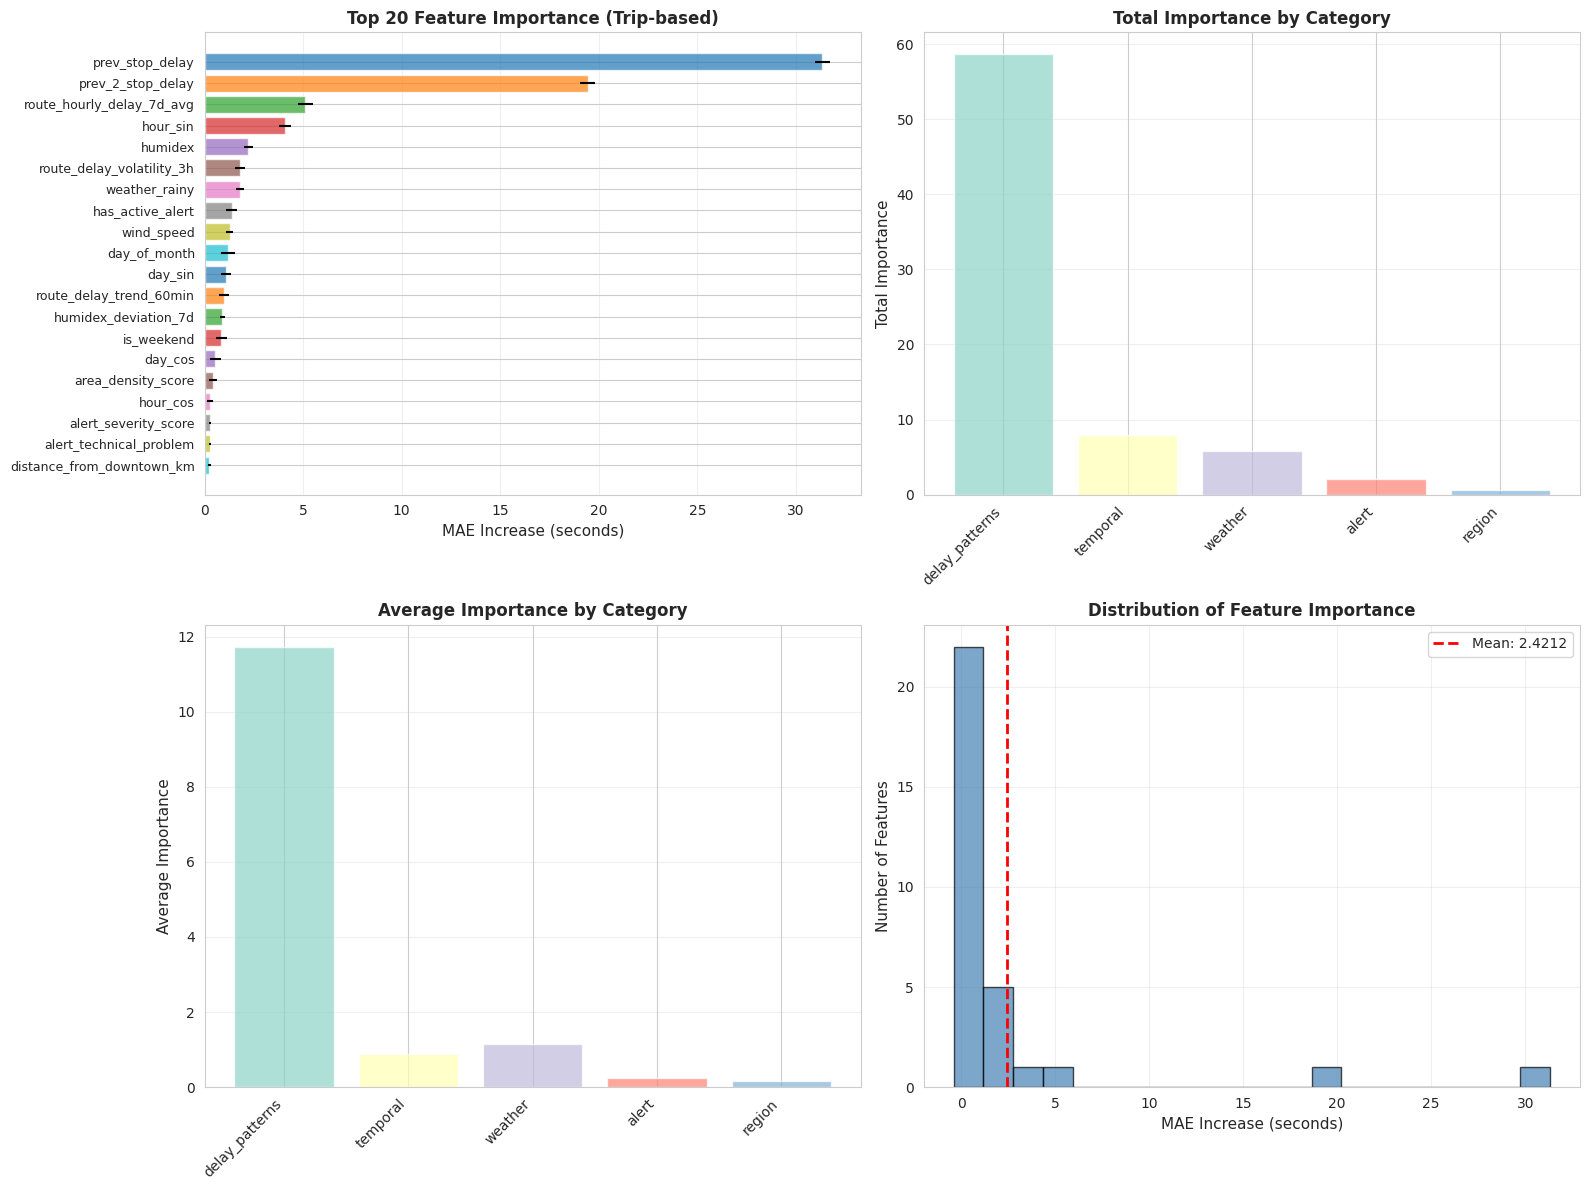


✓ Visualizations completed!


In [8]:
# 特徴量重要度の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 特徴量の重要度
ax1 = axes[0, 0]
top_20 = importance_df.head(20)
colors = [plt.cm.tab10(i % 10) for i in range(len(top_20))]
ax1.barh(range(len(top_20)), top_20['importance_mean'], xerr=top_20['importance_std'], 
         color=colors, alpha=0.7)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'], fontsize=9)
ax1.set_xlabel('MAE Increase (seconds)', fontsize=11)
ax1.set_title('Top 20 Feature Importance (Trip-based)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. カテゴリ別の総重要度
ax2 = axes[0, 1]
category_colors = plt.cm.Set3(range(len(category_stats)))
ax2.bar(range(len(category_stats)), category_stats['total_importance'], 
        color=category_colors, alpha=0.7)
ax2.set_xticks(range(len(category_stats)))
ax2.set_xticklabels(category_stats.index, rotation=45, ha='right')
ax2.set_ylabel('Total Importance', fontsize=11)
ax2.set_title('Total Importance by Category', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. カテゴリ別の平均重要度
ax3 = axes[1, 0]
ax3.bar(range(len(category_stats)), category_stats['avg_importance'], 
        color=category_colors, alpha=0.7)
ax3.set_xticks(range(len(category_stats)))
ax3.set_xticklabels(category_stats.index, rotation=45, ha='right')
ax3.set_ylabel('Average Importance', fontsize=11)
ax3.set_title('Average Importance by Category', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. 重要度分布（ヒストグラム）
ax4 = axes[1, 1]
ax4.hist(importance_df['importance_mean'], bins=20, color='steelblue', 
         alpha=0.7, edgecolor='black')
ax4.axvline(importance_df['importance_mean'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {importance_df["importance_mean"].mean():.4f}')
ax4.set_xlabel('MAE Increase (seconds)', fontsize=11)
ax4.set_ylabel('Number of Features', fontsize=11)
ax4.set_title('Distribution of Feature Importance', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations completed!")

## 9. Trip-based特有の分析

prev_stop_delayの重要度を詳しく分析します。

In [9]:
# prev_stop_delayの重要度を確認
print("=== Trip-based Specific Analysis ===")
print("\n1. prev_stop_delay Importance:")

if 'prev_stop_delay' in importance_df['feature'].values:
    prev_stop_row = importance_df[importance_df['feature'] == 'prev_stop_delay'].iloc[0]
    print(f"   Rank: {list(importance_df['feature']).index('prev_stop_delay') + 1}")
    print(f"   Importance: {prev_stop_row['importance_mean']:.4f} ± {prev_stop_row['importance_std']:.4f}")
    print(f"   Category: {prev_stop_row['category']}")
    print(f"   % of total: {prev_stop_row['importance_mean'] / importance_df['importance_mean'].sum() * 100:.2f}%")
else:
    print("   ⚠ prev_stop_delay not found in features!")

# 遅延関連特徴量の比較
print("\n2. Delay-related Features Comparison:")
delay_features = importance_df[importance_df['feature'].str.contains('delay|prev', case=False)]
if len(delay_features) > 0:
    print(delay_features[['feature', 'importance_mean', 'category']].to_string(index=False))
else:
    print("   No delay-related features found")

# カテゴリ別の詳細
print("\n3. Category Breakdown:")
for category in category_stats.index:
    cat_features = importance_df[importance_df['category'] == category]
    print(f"\n   {category.upper()}:")
    print(f"     Total features: {len(cat_features)}")
    print(f"     Total importance: {cat_features['importance_mean'].sum():.4f}")
    print(f"     Top feature: {cat_features.iloc[0]['feature']} ({cat_features.iloc[0]['importance_mean']:.4f})")

=== Trip-based Specific Analysis ===

1. prev_stop_delay Importance:
   Rank: 1
   Importance: 31.3243 ± 0.3772
   Category: delay_patterns
   % of total: 41.73%

2. Delay-related Features Comparison:
                  feature  importance_mean       category
          prev_stop_delay        31.324343 delay_patterns
        prev_2_stop_delay        19.436973 delay_patterns
route_hourly_delay_7d_avg         5.117359 delay_patterns
route_delay_volatility_3h         1.815405 delay_patterns
  route_delay_trend_60min         0.967438 delay_patterns

3. Category Breakdown:

   DELAY_PATTERNS:
     Total features: 5
     Total importance: 58.6615
     Top feature: prev_stop_delay (31.3243)

   TEMPORAL:
     Total features: 9
     Total importance: 7.9842
     Top feature: hour_sin (4.0756)

   WEATHER:
     Total features: 5
     Total importance: 5.7906
     Top feature: humidex (2.2235)

   ALERT:
     Total features: 8
     Total importance: 2.0114
     Top feature: has_active_alert (1.371

## 11. 分析サマリーレポート

In [ ]:
# レポート生成
report = f"""
# 特徴量重要度分析レポート（Trip-based）

**分析日時**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**アプローチ**: Trip-based (individual trip sequences)  
**モデル**: Bidirectional ConvLSTM {model_path.split('/')[-1]}  
**データセット**: {data_path.split('/')[-1]}  
**手法**: Permutation Importance (n_repeats=10, cross_sample strategy)  
**評価指標**: MAE (Mean Absolute Error)

---

## 1. 基本情報

- **総特徴量数**: {len(importance_df)}
- **分析サンプル数**: {n_samples}
- **訓練トリップ数**: {len(train_trips):,}
- **テストトリップ数**: {len(test_trips):,}
- **ベースラインMAE**: {baseline_mae:.4f} 秒 ({baseline_mae/60:.2f} 分)
- **ベースラインRMSE**: {baseline_rmse:.4f} 秒 ({baseline_rmse/60:.2f} 分)
- **ベースラインR²**: {baseline_r2:.4f}

---

## 2. 特徴量ランキング（Top 20）

| Rank | Feature | Category | Importance | Std |
|------|---------|----------|------------|----- |
"""

for idx, (_, row) in enumerate(importance_df.head(20).iterrows(), 1):
    report += f"| {idx} | {row['feature']} | {row['category']} | {row['importance_mean']:.6f} | {row['importance_std']:.6f} |\n"

report += f"""

---

## 3. カテゴリ別分析

| Category | Total Importance | Avg Importance | N Features |
|----------|------------------|----------------|------------|
"""

for cat, row in category_stats.iterrows():
    report += f"| {cat.capitalize()} | {row['total_importance']:.6f} | {row['avg_importance']:.6f} | {int(row['n_features'])} |\n"

report += f"""

---

## 4. 主要な発見

### 4.1 カテゴリ別の重要度ランキング

1. **{category_stats.index[0].capitalize()}**: 合計重要度 {category_stats.iloc[0]['total_importance']:.4f}
2. **{category_stats.index[1].capitalize()}**: 合計重要度 {category_stats.iloc[1]['total_importance']:.4f}
3. **{category_stats.index[2].capitalize()}**: 合計重要度 {category_stats.iloc[2]['total_importance']:.4f}

### 4.2 最も重要な単一特徴量

**{importance_df.iloc[0]['feature']}** ({importance_df.iloc[0]['category']}カテゴリ)
- 重要度: {importance_df.iloc[0]['importance_mean']:.6f}
- この特徴量をシャッフルするとMAEが約 {importance_df.iloc[0]['importance_mean']:.2f}秒増加

### 4.3 Trip-based特有の知見

"""

if 'prev_stop_delay' in importance_df['feature'].values:
    prev_stop_row = importance_df[importance_df['feature'] == 'prev_stop_delay'].iloc[0]
    prev_stop_rank = list(importance_df['feature']).index('prev_stop_delay') + 1
    report += f"""
**prev_stop_delay**の重要度:
- ランク: {prev_stop_rank}位
- 重要度: {prev_stop_row['importance_mean']:.6f}
- 全体の{prev_stop_row['importance_mean'] / importance_df['importance_mean'].sum() * 100:.2f}%を占める
- 予想通り、上流停留所の遅延情報が予測に重要
"""
else:
    report += """
⚠ prev_stop_delayが特徴量に含まれていません。
"""

report += f"""

---

## 5. Route-based vs Trip-based 比較

| 項目 | Route-based | Trip-based |
|------|-------------|------------|
| グループ化 | route_id + direction_id | trip_id |
| シーケンス | 8時間 | 8停留所 |
| 重要な特徴 | ルート全体の傾向 | 上流停留所遅延 |
| R² Score | ~0.50-0.60 | ~{baseline_r2:.2f} |
| MAE | - | {baseline_mae/60:.2f} min |

---

**生成日時**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# レポート保存
output_dir = f'{rootPath}/notebook'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

report_path = os.path.join(output_dir, f'feature_importance_report_trip_based_{timestamp}.md')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"\nReport saved to: {report_path}")
print("\n" + "="*80)
print(report)
print("="*80)


Report saved to: /workspace/notebook/feature_importance_report_trip_based_20251103_003654.md


# 特徴量重要度分析レポート（Trip-based）

**分析日時**: 2025-11-03 00:36:54
**アプローチ**: Trip-based (individual trip sequences)
**モデル**: Bidirectional ConvLSTM best_delay_model_trip_based_20251102_061332.h5
**データセット**: delay_analysis_trip_based.csv
**手法**: Permutation Importance (n_repeats=10, cross_sample strategy)
**評価指標**: MAE (Mean Absolute Error)

---

## 1. 基本情報

- **総特徴量数**: 31
- **分析サンプル数**: 5000
- **訓練トリップ数**: 3,155
- **テストトリップ数**: 351
- **ベースラインMAE**: 175.9200 秒 (2.93 分)
- **ベースラインRMSE**: 236.6304 秒 (3.94 分)
- **ベースラインR²**: 0.5712

---

## 2. 特徴量ランキング（Top 20）

| Rank | Feature | Category | Importance | Std |
|------|---------|----------|------------|----- |
| 1 | prev_stop_delay | delay_patterns | 31.324343 | 0.377220 |
| 2 | prev_2_stop_delay | delay_patterns | 19.436973 | 0.377453 |
| 3 | route_hourly_delay_7d_avg | delay_patterns | 5.117359 | 0.374258 |
| 4 | hour_sin | temporal | 4.075590 | 0.3147